In [12]:
import sqlite3
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import nltk
import re
import string
import spacy
import itertools
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors
import time
import scipy.sparse
from gensim import matutils,models
from gensim import corpora
from gensim.models.coherencemodel import CoherenceModel
from nltk import pos_tag
import time
import numpy as np
import multiprocess as mp
import warnings
warnings.filterwarnings("ignore")

In [13]:
#Connecting to the sqlite database and fetching all the data
conn = sqlite3.connect("C:/Users/pares/Downloads/18_2157_compressed_database.sqlite/database.sqlite")
data = pd.read_sql_query(""" 
SELECT *
FROM Reviews
""",conn)

In [14]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
Id                        568454 non-null int64
ProductId                 568454 non-null object
UserId                    568454 non-null object
ProfileName               568454 non-null object
HelpfulnessNumerator      568454 non-null int64
HelpfulnessDenominator    568454 non-null int64
Score                     568454 non-null int64
Time                      568454 non-null int64
Summary                   568454 non-null object
Text                      568454 non-null object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


#### We have a total of 568,454 reviews. We dont know what the product is, all we know if a productID given by a user with userID. From this data, since we do not know anything about the reviews - what the reviews are about? - we can perform topic modelling to understand the "topics" on which these set of docments is based.
- We can use the Summary field to understand more about the reviews on which we aim to perform our topic analysis.

In [15]:
#Cleaning data, and retaining only the necessary columns (we can consider Id column as the document-ID)
clean_data = data[["Id","Summary","Text"]]
clean_data.columns = ["id","title","review"]
clean_data.head()

,id,title,review
0,1,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


## Data Exploration

count    568454.000000
mean        436.222083
std         445.339741
min          12.000000
25%         179.000000
50%         302.000000
75%         527.000000
max       21409.000000
Name: review, dtype: float64

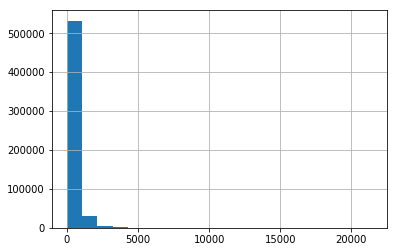

In [16]:
#How long are our reviews?
clean_data.review.apply(len).hist(bins =20)
clean_data.review.apply(len).describe()

Mostly, reviews are short paragraphs with a few exaggerated reviews.

In [17]:
#Longest review
clean_data.loc[clean_data.review.apply(len).idxmax(clean_data.review.apply(len))]

id                                                   290808
title     An okay filtered municipal tap water with slig...
review    Fuzzy Wuzzy's Summary:<br />*** Somewhat recom...
Name: 290807, dtype: object

Since, the dataset is huge, it will take a lot of time performing different things on the entire set. I dont want to spend a lot of time waiting, so will take a sample from the original dataset to explore and learn more about the data, but will use the entire dataset for modelling purposes.

In [18]:
#sample - selecting 10,000 records from the entire dataset
sample = clean_data.sample(10000)
sample = sample.reset_index(drop = True)
sample.head()

,id,title,review
0,543426,Sojos almost killed my dog,"My dog, a 3-year-old chocolate lab with no his..."
1,414170,flavor free is not a way I'd start like to sta...,I bought this 12 pack so that I would have no ...
2,493171,Ew.,I bought a 24 pack of this an drank almost all...
3,482006,Excellent product,This dog food is excellent! My Shih Tzu's are ...
4,364840,Excellent machine for the price.,This popcorn is very convenient and tastes gre...


In [19]:
#How many unique words are there?
import itertools
words = list(itertools.chain(*list(sample.review.apply(word_tokenize))))
len(set(words))

31258

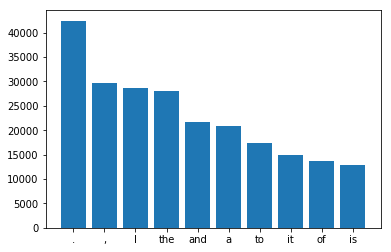

In [20]:
import operator
sorted_words = {k:v for k,v in sorted(Counter(words).items(),key = operator.itemgetter(1),reverse = True)}
plt.bar(list(itertools.islice(sorted_words.keys(),10)),list(itertools.islice(sorted_words.values(),10)))
plt.show()

We have a lot of unique words from the sampled data. But since, these are reviews, I expect a lot of stop-words and similar meaning words (car, cars, etc.). These unqiue words also include punctuations.

## Data Cleaning

- There are few cleaning steps that we will perform before moving forward on our reviews:
  1. Lower-case the text
  2. Remove numbers
  3. Remove extra white-spaces(if any)
  4. Remove Punctuation
  5. Tokenize reviews
  6. Remove Stop-words
  7. Lemmatize all words (I prefer lemmatizing instead of stemming - in my final topics, I need coherent words, and not just random words)
  
  
* For stop-words, we will be using an iterative list, which we will begin with an extra long list of stop-words from rank.nl (around 600 words), and then keep on adding domain specific terms as and when we counter through building initial topic models.
* We will also create and consider bi-grams and tri-grams in our model to get the best possible set of topics.

In [21]:
#loading spacy -en
nlp = spacy.load(r'C:\Users\pares\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.1.0', disable=['parser', 'ner'])

#function to clean the reviews
def clean_text(text):
    text = text.lower() #lower-casing
    text = [i for i in word_tokenize(text) if i not in stop_words] #remvoving stop-words
    doc = nlp(' '.join(text))
    text = [token.lemma_ for token in doc] #lemmatizing the reviews
    text = ' '.join(text)    
    text = re.sub(r'\d+','',text) #removing numbers
    text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
    text = text.strip() #removing white-spaces
    return text

In [22]:
#Initial list of stop-words (from rank.nl)
stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep",	"keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure",	"t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero"]


In [23]:
#function to input the cleaning function to multi-core processing
def clean_apply(df):
    from nltk.tokenize import word_tokenize
    import re
    import spacy
    import string

    stop_words = ["a","able","about","above","abst","accordance","according","accordingly","across","act","actually","added","adj","affected","affecting","affects","after","afterwards","again","against","ah","all","almost","alone","along","already","also","although","always","am","among","amongst","an","and","announce","another","any","anybody","anyhow","anymore","anyone","anything","anyway","anyways","anywhere","apparently","approximately","are","aren","arent","arise","around","as","aside","ask","asking","at","auth","available","away","awfully","b","back","be","became","because","become","becomes","becoming","been","before","beforehand","begin","beginning","beginnings","begins","behind","being","believe","below","beside","besides","between","beyond","biol","both","brief","briefly","but","by","c","ca","came","can","cannot","can't","cause","causes","certain","certainly","co","com","come","comes","contain","containing","contains","could","couldnt","d","date","did","didn't","different","do","does","doesn't","doing","done","don't","down","downwards","due","during","e","each","ed","edu","effect","eg","eight","eighty","either","else","elsewhere","end","ending","enough","especially","et","et-al","etc","even","ever","every","everybody","everyone","everything","everywhere","ex","except","f","far","few","ff","fifth","first","five","fix","followed","following","follows","for","former","formerly","forth","found","four","from","further","furthermore","g","gave","get","gets","getting","give","given","gives","giving","go","goes","gone","got","gotten","h","had","happens","hardly","has","hasn't","have","haven't","having","he","hed","hence","her","here","hereafter","hereby","herein","heres","hereupon","hers","herself","hes","hi","hid","him","himself","his","hither","home","how","howbeit","however","hundred","i","id","ie","if","i'll","im","immediate","immediately","importance","important","in","inc","indeed","index","information","instead","into","invention","inward","is","isn't","it","itd","it'll","its","itself","i've","j","just","k","keep",	"keeps","kept","kg","km","know","known","knows","l","largely","last","lately","later","latter","latterly","least","less","lest","let","lets","like","liked","likely","line","little","'ll","look","looking","looks","ltd","m","made","mainly","make","makes","many","may","maybe","me","mean","means","meantime","meanwhile","merely","mg","might","million","miss","ml","more","moreover","most","mostly","mr","mrs","much","mug","must","my","myself","n","na","name","namely","nay","nd","near","nearly","necessarily","necessary","need","needs","neither","never","nevertheless","new","next","nine","ninety","no","nobody","non","none","nonetheless","noone","nor","normally","nos","not","noted","nothing","now","nowhere","o","obtain","obtained","obviously","of","off","often","oh","ok","okay","old","omitted","on","once","one","ones","only","onto","or","ord","other","others","otherwise","ought","our","ours","ourselves","out","outside","over","overall","owing","own","p","page","pages","part","particular","particularly","past","per","perhaps","placed","please","plus","poorly","possible","possibly","potentially","pp","predominantly","present","previously","primarily","probably","promptly","proud","provides","put","q","que","quickly","quite","qv","r","ran","rather","rd","re","readily","really","recent","recently","ref","refs","regarding","regardless","regards","related","relatively","research","respectively","resulted","resulting","results","right","run","s","said","same","saw","say","saying","says","sec","section","see","seeing","seem","seemed","seeming","seems","seen","self","selves","sent","seven","several","shall","she","shed","she'll","shes","should","shouldn't","show","showed","shown","showns","shows","significant","significantly",
               "similar","similarly","since","six","slightly","so","some","somebody","somehow","someone","somethan","something","sometime","sometimes","somewhat","somewhere","soon","sorry","specifically","specified","specify","specifying","still","stop","strongly","sub","substantially","successfully","such","sufficiently","suggest","sup","sure",	"t","take","taken","taking","tell","tends","th","than","thank","thanks","thanx","that","that'll","thats","that've","the","their","theirs","them","themselves","then","thence","there","thereafter","thereby","thered","therefore","therein","there'll","thereof","therere","theres","thereto","thereupon","there've","these","they","theyd","they'll","theyre","they've","think","this","those","thou","though","thoughh","thousand","throug","through","throughout","thru","thus","til","tip","to","together","too","took","toward","towards","tried","tries","truly","try","trying","ts","twice","two","u","un","under","unfortunately","unless","unlike","unlikely","until","unto","up","upon","ups","us","use","used","useful","usefully","usefulness","uses","using","usually","v","value","various","'ve","very","via","viz","vol","vols","vs","w","want","wants","was","wasnt","way","we","wed","welcome","we'll","went","were","werent","we've","what","whatever","what'll","whats","when","whence","whenever","where","whereafter","whereas","whereby","wherein","wheres","whereupon","wherever","whether","which","while","whim","whither","who","whod","whoever","whole","who'll","whom","whomever","whos","whose","why","widely","willing","wish","with","within","without","wont","words","world","would","wouldnt","www","x","y","yes","yet","you","youd","you'll","your","youre","yours","yourself","yourselves","you've","z","zero"]
    nlp = spacy.load(r'C:\Users\pares\AppData\Local\Continuum\anaconda3\Lib\site-packages\en_core_web_sm\en_core_web_sm-2.1.0', disable=['parser', 'ner'])
    
    def clean_text(text):
        text = text.lower() #lower-casing
        text = [i for i in word_tokenize(text) if i not in stop_words] #remvoving stop-words
        doc = nlp(' '.join(text))
        text = [token.lemma_ for token in doc] #lemmatizing the reviews
        text = ' '.join(text)    
        text = re.sub(r'\d+','',text) #removing numbers
        text = text.translate(str.maketrans('','',string.punctuation)) #removing punctuation
        text = text.strip() #removing white-spaces
        return text
    df['review'] = df.review.apply(clean_text)
    return df

In [24]:
#function to perform data cleaning using parallel processing
start = time.time()

def parallelize(dataframe,func):
    dataframe_split = np.array_split(dataframe,partitions)
    pool = mp.Pool(cores)
    dataframe_return = pd.concat(pool.map(func,dataframe_split),ignore_index = True)
    pool.close()
    
    return dataframe_return


if __name__ == '__main__':
    #mp.set_start_method('spawn')
    cores = mp.cpu_count()
    partitions = cores
    
    clean_data = parallelize(clean_data,clean_apply)
    
    
    end = time.time()
    
    #time taken to remove non-frequent words
    hours, rem = divmod(end-start, 3600)
    minutes, seconds = divmod(rem, 60)
    print("Total time taken to clean","{:0>2}:{:0>2}:{:05.2f}".format(int(hours),int(minutes),seconds))

Total time taken to clean 00:42:00.85


In [28]:
#sanity check
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 3 columns):
id        568454 non-null int64
title     568454 non-null object
review    568454 non-null object
dtypes: int64(1), object(2)
memory usage: 13.0+ MB


In [29]:
#saving the cleaned reviews
clean_data.to_pickle('clean_data.pkl')